In [26]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, add
from tensorflow.keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Flatten, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend, layers
import numpy as np
import matplotlib.pyplot as plt 
import h5py

In [14]:
#"phenomene","pitch","tension","breathiness","voicing","gender","toneshift"
N=10500
data_path='C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\dataset\\'
data_x=np.zeros(shape=(N,128,128,1),dtype=(np.float))
for i in range(N):
    if (i/N*100)%5==0:
        print('%d'%(i/N*100)+'%')
    t=h5py.File(data_path+'%05d.mat'%(i+1))
    t=t['MEL'][:]
    t=np.log(t+1e-20)+40
    data_x[i,:,:,0]=t

f=open(data_path+'params.txt')
range_param=[[-1,1],[-1,1],[0.2,1],[-0.1,0.1],[-400,400]]
data_y=[];
for line in f:
    data_y.append(line.split())
    data_y[-1]=data_y[-1][2:]
    for i in range(5):
        data_y[-1][i]=(float(data_y[-1][i])-range_param[i][0])/(range_param[i][1]-range_param[i][0])


data_path='C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\dataset2\\'
data_x2=np.zeros(shape=(N,128,128,1),dtype=(np.float))
for i in range(N):
    if (i/N*100)%5==0:
        print('%d'%(i/N*100)+'%')
    t=h5py.File(data_path+'%05d.mat'%(i+1))
    t=t['MEL'][:]
    t=np.log(t+1e-20)+40
    data_x2[i,:,:,0]=t

f=open(data_path+'params.txt')
data_y2=[];
for line in f:
    data_y2.append(line.split())
    data_y2[-1]=data_y2[-1][4:]
    for i in range(5):
        data_y2[-1][i]=(float(data_y2[-1][i])-range_param[i][0])/(range_param[i][1]-range_param[i][0])
    data_y2.append(data_y2[-1])
    data_y2.append(data_y2[-1])
    

0%


d:\software\python36x64\lib\site-packages\ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
0%


d:\software\python36x64\lib\site-packages\ipykernel_launcher.py:28: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%


In [15]:
data_y=np.array(data_y+data_y2)
data_x=np.concatenate((data_x,data_x2),axis=0)
print(np.shape(data_x))
print(np.shape(data_y))
print(data_y[0:8])

(21000, 128, 128, 1)
(21000, 5)
[[0.26595201 0.13623012 0.92718824 0.63776558 0.52257525]
 [0.2575118  0.71256601 0.68548969 0.7613134  0.02583366]
 [0.24246172 0.9912542  0.12439311 0.1307294  0.23294286]
 [0.43862696 0.38810604 0.54409367 0.68510699 0.80876019]
 [0.61888165 0.94831497 0.80089061 0.68580182 0.79100108]
 [0.91513386 0.76900182 0.87342505 0.54948081 0.00876195]
 [0.10081981 0.27638711 0.70937793 0.96413431 0.78879402]
 [0.19514533 0.37449687 0.17123794 0.22134501 0.77415296]]


35.120609540421206
-6.0517018598809145


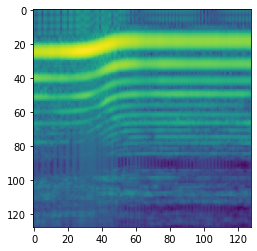

In [18]:
plt.imshow(np.transpose(data_x[19000,:,:,0]))
print(np.max(data_x[:,:,:,0]))
print(np.min(data_x[:,:,:,0]))

In [30]:
def conv_block(inputs, 
        neuron_num, 
        kernel_size,  
        use_bias, 
        padding= 'same',
        strides= (1, 1),
        with_conv_short_cut = False):
    conv1 = Conv2D(
        neuron_num,
        kernel_size = kernel_size,
        activation= 'relu',
        strides= strides,
        use_bias= use_bias,
        padding= padding
    )(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)

    conv2 = Conv2D(
        neuron_num,
        kernel_size= kernel_size,
        activation= 'relu',
        use_bias= use_bias,
        padding= padding)(conv1)
    conv2 = BatchNormalization(axis = 1)(conv2)

    if with_conv_short_cut:
        inputs = Conv2D(
            neuron_num, 
            kernel_size= kernel_size,
            strides= strides,
            use_bias= use_bias,
            padding= padding
            )(inputs)
        return add([inputs, conv2])

    else:
        return add([inputs, conv2])

inputs = Input(shape= [128, 128, 1])
x = ZeroPadding2D((3, 3))(inputs)

# Define the converlutional block 1
x = Conv2D(64, kernel_size= (7, 7), strides= (2, 2), padding= 'valid')(x)
x = BatchNormalization(axis= 1)(x)
x = MaxPooling2D(pool_size= (3, 3), strides= (2, 2), padding= 'same')(x)

# Define the converlutional block 2
x = conv_block(x, neuron_num= 64, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 64, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 64, kernel_size= (3, 3), use_bias= True)

# Define the converlutional block 3
x = conv_block(x, neuron_num= 128, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
x = conv_block(x, neuron_num= 128, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 128, kernel_size= (3, 3), use_bias= True)

# Define the converlutional block 4
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 256, kernel_size= (3, 3), use_bias= True)

# Define the converltional block 5
x = conv_block(x, neuron_num= 512, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
x = conv_block(x, neuron_num= 512, kernel_size= (3, 3), use_bias= True)
x = conv_block(x, neuron_num= 512, kernel_size= (3, 3), use_bias= True)
x = AveragePooling2D(pool_size=(7, 7),padding="same")(x)
x = Flatten()(x)
x = Dense(1000)(x)
x = Dropout(0.5)(x)
y = Dense(5)(x)

model = Model(inputs= inputs, outputs= y)

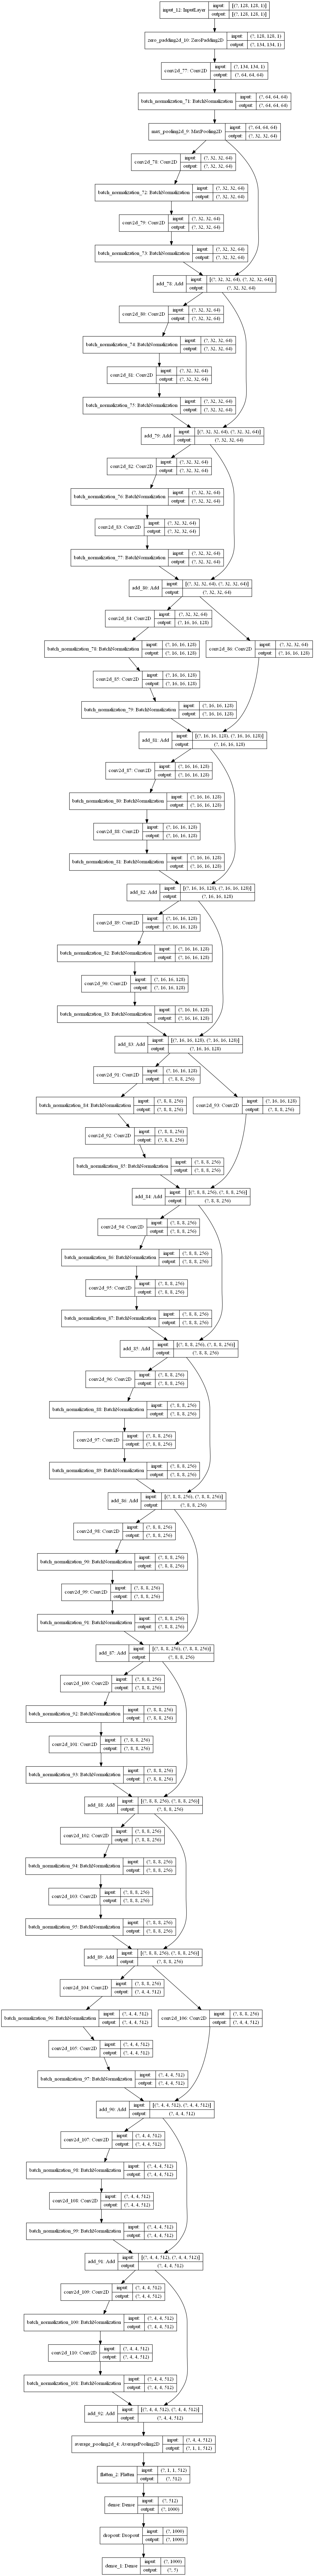

In [31]:
#model.summary()
plot_model(model,show_shapes=True,expand_nested=True)

In [40]:
index=10
print(np.shape(np.expand_dims(data_x[index,:,:,:],0)))
print(np.shape(np.expand_dims(data_y[index,:],0)))
model.compile(loss='mean_squared_error',optimizer='SGD')
history=model.fit(data_x,data_y,epochs=100,verbose=1,validation_split=0.3,use_multiprocessing=False)

(1, 128, 128, 1)
(1, 5)
Train on 14699 samples, validate on 6301 samples
Epoch 1/100
14699/14699 [==============================] - 61s 4ms/sample - loss: 0.0111 - val_loss: 0.0252
Epoch 2/100
14699/14699 [==============================] - 56s 4ms/sample - loss: 0.0098 - val_loss: 0.0247
Epoch 3/100
14699/14699 [==============================] - 56s 4ms/sample - loss: 0.0094 - val_loss: 0.0245
Epoch 4/100
14699/14699 [==============================] - 56s 4ms/sample - loss: 0.0092 - val_loss: 0.0244
Epoch 5/100
14699/14699 [==============================] - 56s 4ms/sample - loss: 0.0091 - val_loss: 0.0244
Epoch 6/100
14699/14699 [==============================] - 58s 4ms/sample - loss: 0.0089 - val_loss: 0.0242
Epoch 7/100
14699/14699 [==============================] - 57s 4ms/sample - loss: 0.0088 - val_loss: 0.0243
Epoch 8/100
14699/14699 [==============================] - 57s 4ms/sample - loss: 0.0088 - val_loss: 0.0242
Epoch 9/100
14699/14699 [==============================] - 58s 

Text(0, 0.5, 'MSE')

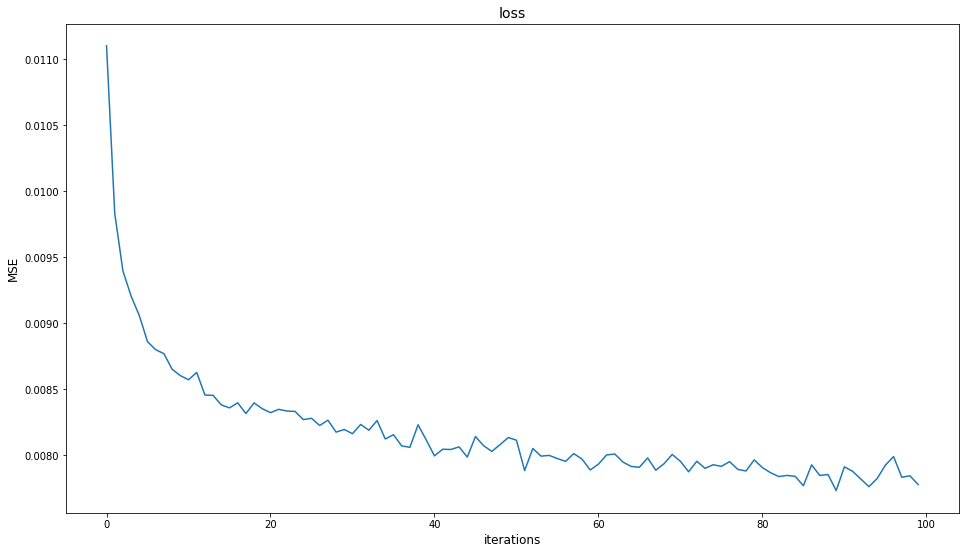

In [42]:
t=history.history['loss']
plt.figure(figsize=(16,9))
plt.plot([i for i in range(np.shape(t)[0])],t)
plt.title('loss',fontsize=14)
plt.xlabel('iterations',fontsize=12)
plt.ylabel('MSE',fontsize=12)
#plt.ylim([0,100])

In [44]:
index=10050
print(np.shape(np.expand_dims(data_x[index],0)))
t=backend.function([model.input],[model.output])(np.expand_dims(data_x[index],0))
t_pred=np.squeeze(t).tolist()
t_true=np.squeeze(data_y[index]).tolist()
#t_input=np.squeeze(x_input).tolist()
print(t_pred)
print(t_true)

(1, 128, 128, 1)
[0.7747089862823486, 0.2930809259414673, 0.47166624665260315, 0.7052358388900757, 0.8849819898605347]
[0.5813314119726185, 0.3507893398725719, 0.5959236218209828, 0.7953847312874909, 0.8293483741393353]


In [45]:
model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\my_model34_mix.h5")

In [46]:
import pickle
 
with open('C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\trainHistory34_mix.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
#with open('trainHistoryDict.txt','rb') as file_pi:
#    history=pickle.load(file_pi)